## Máster en Data Science - Series Temporales

# Facebook's Prophet Model
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

Facebook Prophet es un modelo de pronóstico de series temporales desarrollado por el equipo de investigación de Facebook, diseñado para ser fácil de usar y eficaz en una amplia variedad de escenarios. Este modelo combina técnicas avanzadas, como descomposición aditiva, ajustes automáticos de estacionalidad, y manejo de días festivos o eventos especiales, lo que lo hace especialmente útil para datos con patrones estacionales, tendencias no lineales y puntos atípicos. Prophet se destaca por su capacidad de ofrecer predicciones robustas con mínimos requerimientos de configuración, adaptándose tanto a series temporales simples como complejas. Además, cuenta con una implementación accesible en Python y R, lo que permite a usuarios con distintos niveles de experiencia aplicar modelos de pronóstico avanzados de manera sencilla y eficiente.

In [7]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics

import warnings
warnings.filterwarnings('ignore')

### Importación de datos

In [2]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [3]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [4]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***

## Modelo Prophet

El modelo Prophet se basa en un enfoque bayesiano para ajustar componentes de tendencia, estacionalidad y eventos especiales de una serie temporal. La tendencia se modela mediante una función piecewise, con puntos de cambio definidos automáticamente que permiten capturar variaciones en la dirección o pendiente de la tendencia. La estacionalidad se representa usando bases Fourier, lo que permite modelar ciclos periódicos de forma flexible y eficiente. Los días festivos o eventos se integran como regresores binarios en el modelo, ajustando su impacto sobre la serie. Prophet utiliza un marco probabilístico que estima distribuciones posteriores de los parámetros, permitiendo incorporar incertidumbre en las predicciones. Su implementación optimizada garantiza un balance entre precisión y facilidad de uso.

In [5]:
df_autobus_month = TimeSeries.from_series(df_autobus_month)
df_autobus_trim = TimeSeries.from_series(df_autobus_trim)
df_combined_month = TimeSeries.from_series(df_combined_month)
df_combined_trim = TimeSeries.from_series(df_combined_trim)
df_metro_month = TimeSeries.from_series(df_metro_month)
df_metro_trim = TimeSeries.from_series(df_metro_trim)

### Series mensuales

18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing


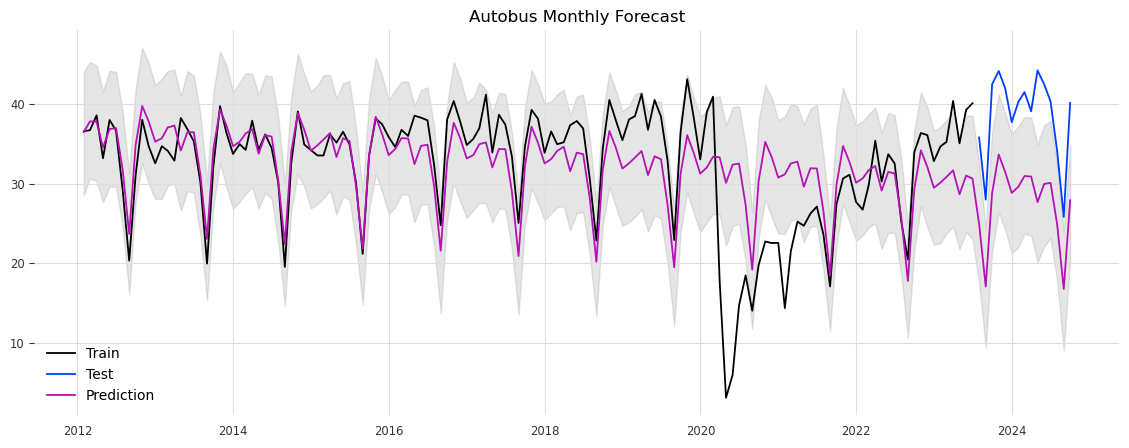

18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing


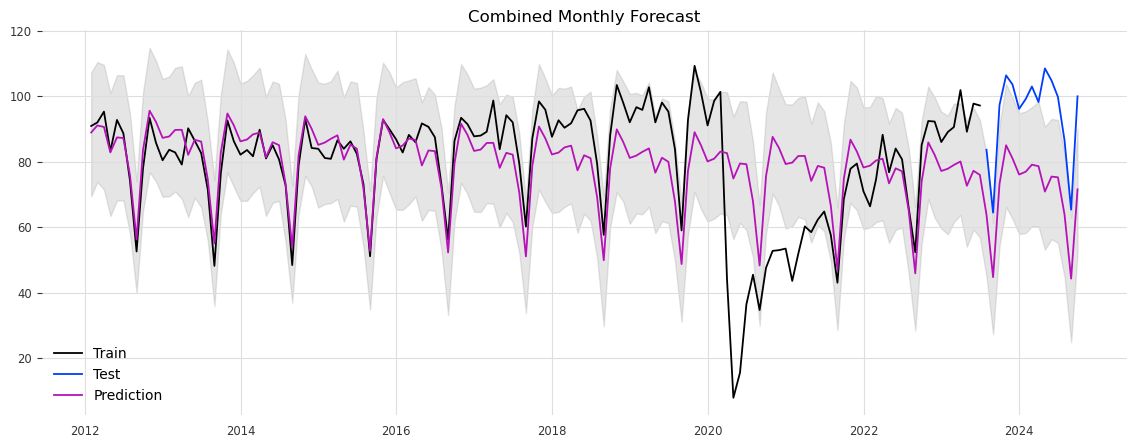

18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing


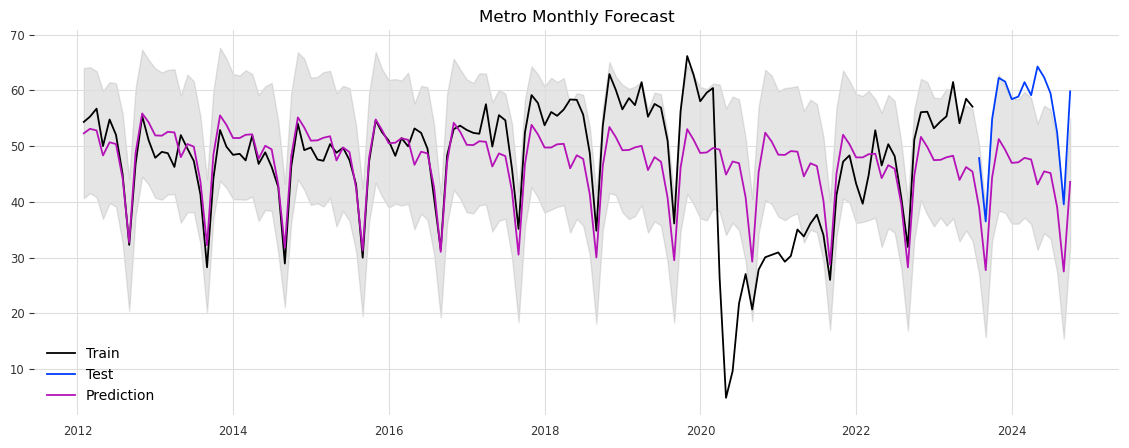

In [20]:
# Función para entrenar y predecir con Prophet
def prophet_forecast(df, periods=15, freq='M'):
    # Convertir el TimeSeries de darts a DataFrame de pandas
    df_pd = df.pd_dataframe().reset_index()
    df_pd.columns = ['ds', 'y']
    
    # Dividir en train y test
    train = df_pd[:-periods]
    test = df_pd[-periods:]
    
    # Entrenar el modelo Prophet
    model = Prophet()
    model.fit(train)
    
    # Crear un dataframe para las fechas futuras
    future = model.make_future_dataframe(periods=periods, freq=freq)
    
    # Realizar predicciones
    forecast = model.predict(future)
    
    return train, test, forecast

# Graficar los resultados
def plot_forecast(train, test, forecast, title):
    plt.figure(figsize=(14, 5))
    plt.plot(train['ds'], train['y'], label='Train')
    plt.plot(test['ds'], test['y'], label='Test')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prediction')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
    plt.title(title)
    plt.legend()
    plt.show()

# Predecir y graficar para df_autobus_month
train_autobus, test_autobus, forecast_autobus = prophet_forecast(df_autobus_month)
plot_forecast(train_autobus, test_autobus, forecast_autobus, 'Autobus Monthly Forecast')

# Predecir y graficar para df_combined_month
train_combined, test_combined, forecast_combined = prophet_forecast(df_combined_month)
plot_forecast(train_combined, test_combined, forecast_combined, 'Combined Monthly Forecast')

# Predecir y graficar para df_metro_month
train_metro, test_metro, forecast_metro = prophet_forecast(df_metro_month)
plot_forecast(train_metro, test_metro, forecast_metro, 'Metro Monthly Forecast')

In [9]:

# Función para calcular las métricas
def calculate_metrics(test, forecast):
    mse = mean_squared_error(test['y'], forecast['yhat'][-len(test):])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test['y'], forecast['yhat'][-len(test):])
    return mse, rmse, mape

# Calcular métricas para df_autobus_month
mse_autobus, rmse_autobus, mape_autobus = calculate_metrics(test_autobus, forecast_autobus)
print(f"Autobus Monthly Forecast - MSE: {mse_autobus}, RMSE: {rmse_autobus}, MAPE: {mape_autobus}")

# Calcular métricas para df_combined_month
mse_combined, rmse_combined, mape_combined = calculate_metrics(test_combined, forecast_combined)
print(f"Combined Monthly Forecast - MSE: {mse_combined}, RMSE: {rmse_combined}, MAPE: {mape_combined}")

# Calcular métricas para df_metro_month
mse_metro, rmse_metro, mape_metro = calculate_metrics(test_metro, forecast_metro)
print(f"Metro Monthly Forecast - MSE: {mse_metro}, RMSE: {rmse_metro}, MAPE: {mape_metro}")

Autobus Monthly Forecast - MSE: 124.2100934392925, RMSE: 11.144958207157734, MAPE: 0.2874883152047716
Combined Monthly Forecast - MSE: 586.622436575882, RMSE: 24.220289770683628, MAPE: 0.25398379989651826
Metro Monthly Forecast - MSE: 176.408319204816, RMSE: 13.281879355152116, MAPE: 0.2316144661055194


El modelo Prophet no consigue realizar buenas predicciones ya que no consigue capturar la tendencia de las series temporales, captura muy bien el componente estacional pero no la tendencia. Esto causa que tanto visualmente como evaluando las métricas, las predicciones no sean nada buenas. Teniendo un error MAPE por encima del 20% en todos los casos.

17:52:26 - cmdstanpy - INFO - Chain [1] start processing
17:52:27 - cmdstanpy - INFO - Chain [1] done processing


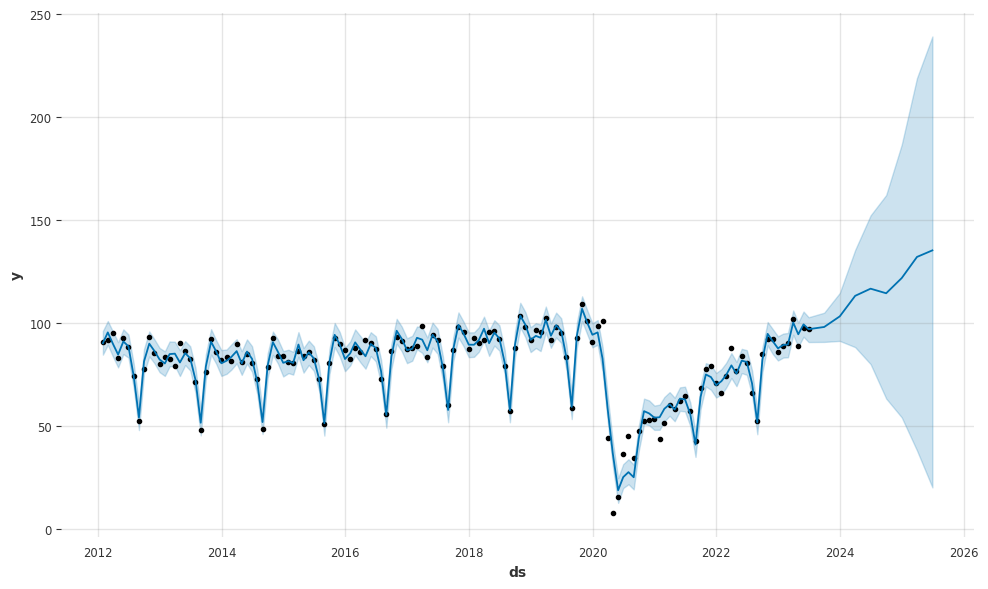

In [16]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality='auto',
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale =.5)
model.add_seasonality(
        name='timestre',
        period=4,
        fourier_order=4)
model.fit(train_combined)
future = model.make_future_dataframe(periods=4 * 2, freq='Q')
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

La gráfica muestra las predicciones del modelo Prophet, donde los puntos negros representan los datos históricos y la línea azul sólida refleja la predicción central del modelo. Las bandas sombreadas azules corresponden al intervalo de confianza, que aumenta en amplitud hacia el futuro, indicando mayor incertidumbre en las predicciones a largo plazo. El modelo parece haber capturado adecuadamente la estacionalidad recurrente y la tendencia general, incluida la recuperación tras una caída observada alrededor de 2020. En las predicciones futuras (2024-2026), se proyecta una tendencia al alza con un rango de incertidumbre creciente.

En este caso solo he graficado la serie temporal combinada, ya que debido a los malos resultados de las predicciones anteriores, no usaré el modelo Prophet para realizar las predicciones finales.

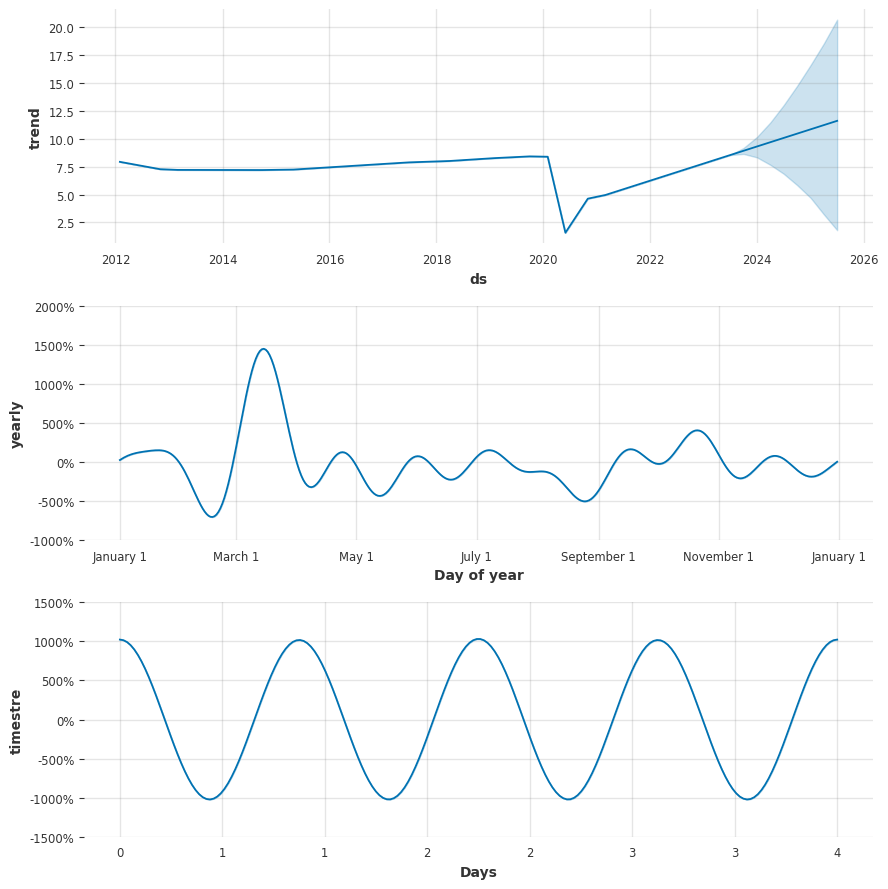

In [19]:
fig = model.plot_components(forecast)
plt.show()

La gráfica muestra la descomposición de los componentes de la serie temporal modelada con Prophet. Se divide en tres subgráficas principales:

1. **Tendencia (gráfico superior)**: Representa la evolución de la tendencia a lo largo del tiempo. La línea azul muestra la trayectoria de la tendencia, mientras que las bandas sombreadas indican el intervalo de confianza, que aumenta hacia el futuro. Observamos una caída notable alrededor de 2020 fruto de la pandemia COVID-19, seguida de una recuperación progresiva y una tendencia al alza hacia 2026. Este componente captura los cambios generales en el nivel de la serie a lo largo del tiempo.

2. **Estacionalidad anual (gráfico del medio)**: Muestra los patrones recurrentes a lo largo del año. Este gráfico indica cómo los valores de la serie varían según el día del año. Por ejemplo, puede haber picos o caídas significativas en meses específicos como marzo, reflejando comportamientos estacionales regulares, como cambios asociados a factores climáticos o ciclos anuales.

3. **Estacionalidad adicional (gráfico inferior)**: Representa otro componente estacional, posiblemente asociado a un ciclo más corto, como un patrón diario o semanal. Aquí se observa un patrón repetitivo con picos y valles pronunciados, lo que sugiere fluctuaciones regulares dentro de períodos más cortos.

En conjunto, estas gráficas descomponen la serie temporal en sus componentes clave, lo que permite interpretar mejor las dinámicas subyacentes y los patrones estacionales que afectan a los datos. Esto ayuda a identificar cómo cada componente contribuye a la evolución general de la serie temporal y a realizar predicciones más precisas.

### Series trimestrales

18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing


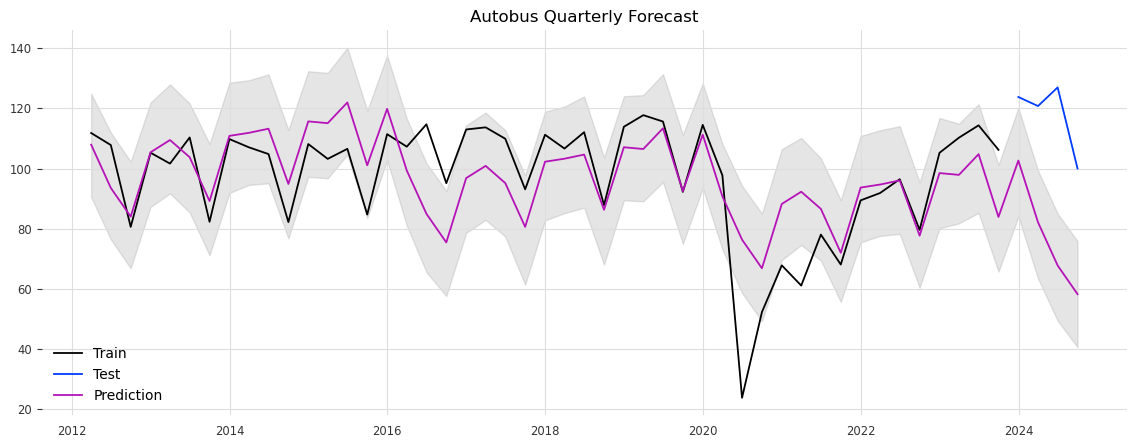

18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing


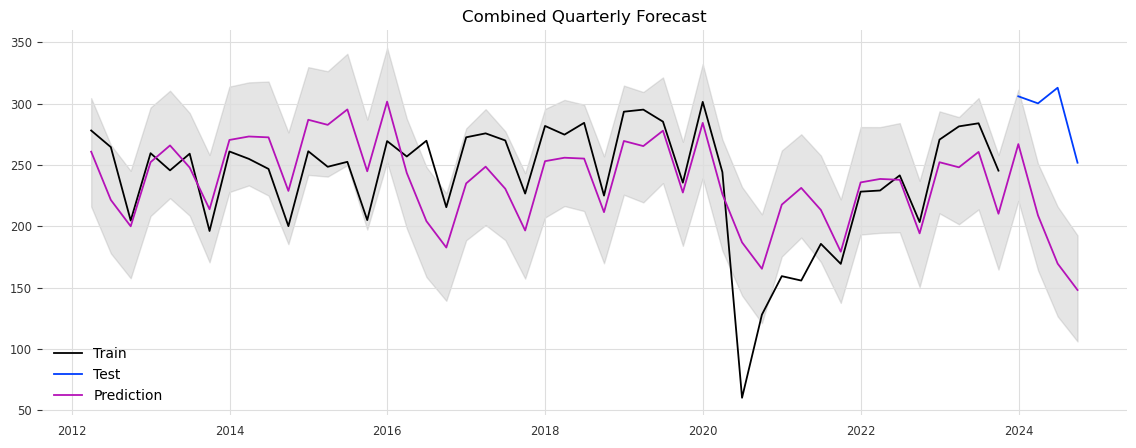

18:03:34 - cmdstanpy - INFO - Chain [1] start processing
18:03:34 - cmdstanpy - INFO - Chain [1] done processing


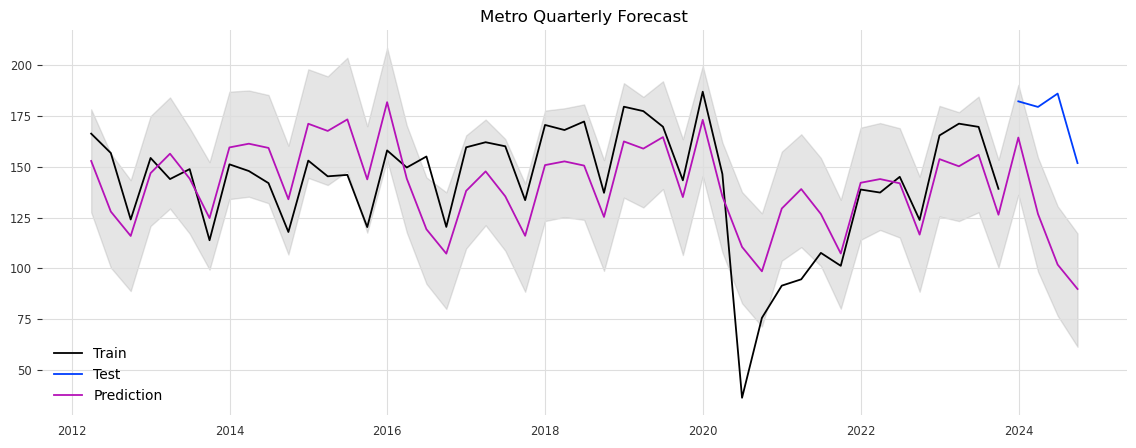

In [22]:
# Predecir y graficar para df_autobus_trim
train_autobus_trim, test_autobus_trim, forecast_autobus_trim = prophet_forecast(df_autobus_trim, periods=4, freq='Q')
plot_forecast(train_autobus_trim, test_autobus_trim, forecast_autobus_trim, 'Autobus Quarterly Forecast')

# Predecir y graficar para df_combined_trim
train_combined_trim, test_combined_trim, forecast_combined_trim = prophet_forecast(df_combined_trim, periods=4, freq='Q')
plot_forecast(train_combined_trim, test_combined_trim, forecast_combined_trim, 'Combined Quarterly Forecast')

# Predecir y graficar para df_metro_trim
train_metro_trim, test_metro_trim, forecast_metro_trim = prophet_forecast(df_metro_trim, periods=4, freq='Q')
plot_forecast(train_metro_trim, test_metro_trim, forecast_metro_trim, 'Metro Quarterly Forecast')

In [23]:
# Calcular métricas para df_autobus_month
mse_autobus_trim, rmse_autobus_trim, mape_autobus_trim = calculate_metrics(test_autobus_trim, forecast_autobus_trim)
print(f"Autobus Monthly Forecast - MSE: {mse_autobus_trim}, RMSE: {rmse_autobus_trim}, MAPE: {mape_autobus_trim}")

# Calcular métricas para df_combined_month
mse_combined_trim, rmse_combined_trim, mape_combined_trim = calculate_metrics(test_combined_trim, forecast_combined_trim)
print(f"Combined Monthly Forecast - MSE: {mse_combined_trim}, RMSE: {rmse_combined_trim}, MAPE: {mape_combined_trim}")

# Calcular métricas para df_metro_month
mse_metro_trim, rmse_metro_trim, mape_metro_trim = calculate_metrics(test_metro_trim, forecast_metro_trim)
print(f"Metro Monthly Forecast - MSE: {mse_metro_trim}, RMSE: {rmse_metro_trim}, MAPE: {mape_metro_trim}")

Autobus Monthly Forecast - MSE: 1796.3876596530658, RMSE: 42.38381365159424, MAPE: 0.3435291273290689
Combined Monthly Forecast - MSE: 10309.901188667154, RMSE: 101.53768358923278, MAPE: 0.32558978921620013
Metro Monthly Forecast - MSE: 3507.548064454378, RMSE: 59.22455626219903, MAPE: 0.31308530982311367


Al igual que en las series mensuales, las predicciones de las series trimestrales no son nada buenas. Observamos errores por encima del 30% en todos los casos.

18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing


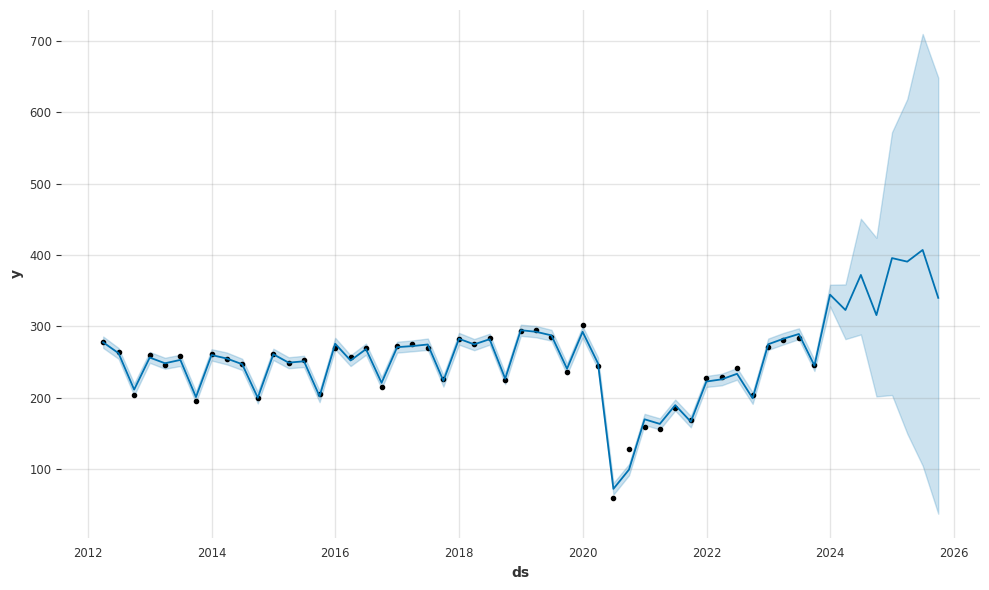

In [24]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality='auto',
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale =.5)
model.add_seasonality(
        name='timestre',
        period=4,
        fourier_order=4)
model.fit(train_combined_trim)
future = model.make_future_dataframe(periods=4 * 2, freq='Q')
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

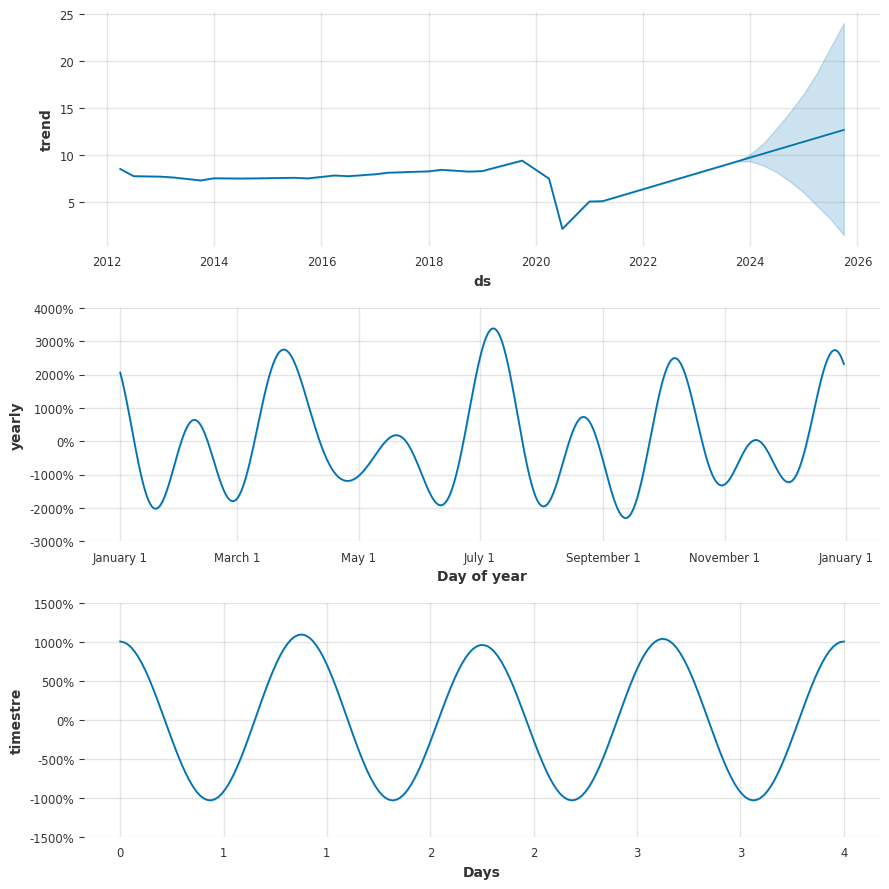

In [25]:
fig = model.plot_components(forecast)
plt.show()

***

## Conclusión Prophet

Las predicciones generadas con el modelo Prophet no resultaron favorables, ya que no lograron capturar de manera adecuada la tendencia aunque si la estacionalidad observadas en los datos históricos de la serie temporal. Aunque Prophet es una herramienta robusta y flexible, su desempeño en este caso fue limitado, posiblemente debido a características complejas de los datos o a patrones no lineales difíciles de modelar. Las proyecciones muestran una alta incertidumbre en el horizonte futuro, lo que reduce la confiabilidad de los resultados para la toma de decisiones. Por lo tanto, se concluye que Prophet no es la mejor opción para esta serie, y será necesario considerar otros modelos que se ajusten mejor a las particularidades de los datos, en nuestros caso siguen siendo los modelos ETS y Theta.